<a href="https://colab.research.google.com/github/Rajeeb321123/Pytorch/blob/master/04_transfer_learning_in_pytorch_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning in pytorch part_1 Feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing architecure proven to work on problems similar to our own.
2. Can leverage a network architecure whic has already learned patterns on similar data to our own, then we can our adapt those patterns to our data.

In [ ]:
%%capture
!pip install kaggle

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


'cuda'

In [ ]:
# Are we using a GPU?
!nvidia-smi

Mon Feb 17 06:03:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data

In [ ]:
import os

# Set Kaggle API credentials
os.environ["KAGGLE_USERNAME"] = ""
os.environ["KAGGLE_KEY"] = ""

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:27<00:00, 23.9MB/s]
100% 586M/586M [00:27<00:00, 22.6MB/s]


In [ ]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/animals10.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# import shutil

# folder_path = "/content/split_data"  # Change to the folder you want to delete

# # Delete the folder and its contents
# shutil.rmtree(folder_path)


In [ ]:
import os
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "cavallo": "horse",  "farfalla":"butterfly", "cow": "mucca",  "ragno":"spider", "scoiattolo":"squirrel" }

os.rename("/content/raw-img", "/content/animals10")
for folder in os.listdir("/content/animals10"):
  os.rename(f"/content/animals10/{folder}", f"/content/animals10/{translate[folder]}")

In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/animals10"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")##

There are 10 directories and 0 images in '/content/animals10'.
There are 0 directories and 1446 images in '/content/animals10/elephant'.
There are 0 directories and 1866 images in '/content/animals10/cow'.
There are 0 directories and 2112 images in '/content/animals10/butterfly'.
There are 0 directories and 4821 images in '/content/animals10/spider'.
There are 0 directories and 1668 images in '/content/animals10/cat'.
There are 0 directories and 3098 images in '/content/animals10/chicken'.
There are 0 directories and 2623 images in '/content/animals10/horse'.
There are 0 directories and 1820 images in '/content/animals10/sheep'.
There are 0 directories and 4863 images in '/content/animals10/dog'.
There are 0 directories and 1862 images in '/content/animals10/squirrel'.


In [ ]:
import os
import shutil
import random

source_folder = "/content/animals10"  # Main dataset folder
train_folder = "/content/10_animals_10%/split_data/train"  # Train dataset (20%)
test_folder = "/content/10_animals_10%/split_data/test"    # Test dataset (5%)

# Create train and test directories
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)


for subdir in os.listdir(source_folder):
    subdir_path = os.path.join(source_folder, subdir)

    if os.path.isdir(subdir_path):  # Ensure it's a directory
        images = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

        # Shuffle images for randomness
        random.shuffle(images)

        # Compute split sizes
        total_images = len(images)
        train_size = max(1, int(0.1 * total_images))  # 20% for training
        test_size = max(1, int(0.01 * total_images))  # 5% for testing

        # Select images for train and test
        train_images = images[:train_size]
        test_images = images[train_size:train_size + test_size]

        # Create subdirectories in train and test folders
        train_subdir = os.path.join(train_folder, subdir)
        test_subdir = os.path.join(test_folder, subdir)

        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Copy images to respective folders
        for img in train_images:
            shutil.copy(img, os.path.join(train_subdir, os.path.basename(img)))

        for img in test_images:
            shutil.copy(img, os.path.join(test_subdir, os.path.basename(img)))

        print(f"Processed '{subdir}': {len(train_images)} train, {len(test_images)} test")


def count_images(folder):
    count = 0
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            count += len(os.listdir(subdir_path))
    return count

print(f"Total Train Images: {count_images(train_folder)}")
print(f"Total Test Images: {count_images(test_folder)}")

Processed 'elephant': 144 train, 14 test
Processed 'cow': 186 train, 18 test
Processed 'butterfly': 211 train, 21 test
Processed 'spider': 482 train, 48 test
Processed 'cat': 166 train, 16 test
Processed 'chicken': 309 train, 30 test
Processed 'horse': 262 train, 26 test
Processed 'sheep': 182 train, 18 test
Processed 'dog': 486 train, 48 test
Processed 'squirrel': 186 train, 18 test
Total Train Images: 2614
Total Test Images: 257


In [ ]:
# Setup the train and test directories
train_dir = "/content/10_animals_10%/split_data/train/"
test_dir="/content/10_animals_10%/split_data/test/"

In [ ]:
# Let's get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['butterfly' 'cat' 'chicken' 'cow' 'dog' 'elephant' 'horse' 'sheep'
 'spider' 'squirrel']


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# to select image randomly image
def view_random_image(target_dir, target_class): #target_dir in directory, target_class is either steak or pizza here
  # Setup the target directory (we'll view iamges from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder  + "/" + random_image[0]) # we random_image in list format so, we change into string path format to read
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape:{img.shape}") # show the shape of the image

  return img

['OIP-6-yzIDw0a1HmzC5o48ZwEQHaEQ.jpeg']
Image shape:(173, 300, 3)


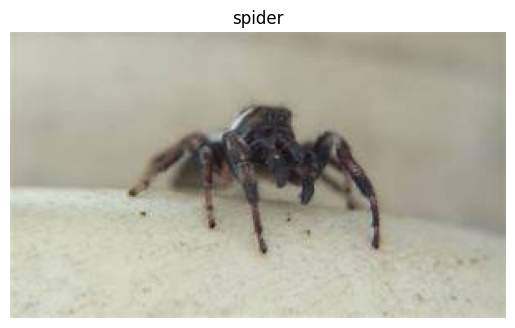

In [ ]:
# Visualize, Visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Augmentation & Batch

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


torch.manual_seed(42)
BATCH_SIZE = 32


# Define transformations for the validation sets
transform_without_augmentation = transforms.Compose([
    transforms.Resize((224, 224)), # resize every image to 64
    transforms.ToTensor(),
])

# Define the transformation for the transform_
transform_with_augmentation =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(
        degrees=20,              # randomly rotate images by -20 to 20 degrees
        translate=(0.2, 0.3),    # randomly shift images: 20% horizontally, 30% vertically
        scale=(0.8, 1.2),        # randomly zoom images: scale ranges from 80% to 120%
        shear=20               # randomly shear images by -20 to 20 degrees
    ),
    transforms.RandomHorizontalFlip(),
    ## above and below are same
    # transforms.RandomRotation(degrees=20),  # Rotates randomly within ±20 degrees
    # transforms.RandomAffine(degrees=0, shear=20),  # Shear transformation
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),  # Zoom effect
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    # transforms.RandomAffine(degrees=0, translate=(0.2, 0.3)),  # Width and height shift
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the datasets with the transformations
train_data = datasets.ImageFolder(root=train_dir, transform=transform_with_augmentation)
valid_data = datasets.ImageFolder(root=test_dir, transform=transform_without_augmentation)

# for the demonstration only in plot. We always augmented
train_data_without_augmented = datasets.ImageFolder(root=train_dir, transform=transform_without_augmentation)

print(f"The total train_data is :{len(train_data)}")
print(f"The total test_data is :{len(valid_data)}")

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

# for demonsatration only in plot
train_dataloader_without_augmented = DataLoader(train_data_without_augmented, batch_size=BATCH_SIZE, shuffle=False)
train_dataLoader_unsuffled = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"The classes are: {train_data.classes}")

The total train_data is :2614
The total test_data is :257
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a5975347250>, <torch.utils.data.dataloader.DataLoader object at 0x7a59754faf50>)
Length of train dataloader: 82 batches of 32
Length of test dataloader: 9 batches of 32
The classes are: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
for each_batch in list(train_dataloader)[-4:]:
  print(each_batch[0].shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([22, 3, 224, 224])


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
showing image number:19


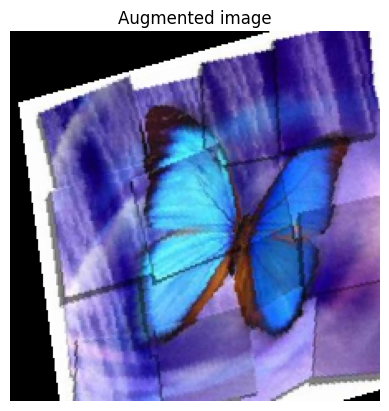

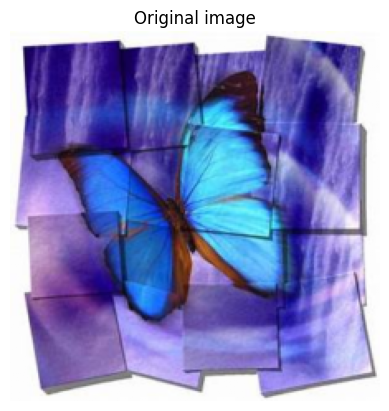

In [ ]:
# Get a batch of data
# When you use next(iter(train_dataloader)), it retrieves the next batch of data from the DataLoader iterator, not specifically the last batch. It fetches batches one by one from the beginning of the DataLoader each time it is invoked until there are no more batches left.
# Get sample data batches (last batch)
images, labels = next(iter(train_dataLoader_unsuffled))


print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")


unaugmented_images, unagmented_labels = next(iter(train_dataloader_without_augmented))

# Show original image and augmented image
import random
random_number = random.randint(0, 32) # our batch size are 32... so random from 0 to 32
print(f"showing image number:{random_number}")
plt.title(f"Augmented image")
plt.imshow(images[random_number].permute(1, 2, 0) ) # we need to do permute for making 224 x 224 x 3
plt.axis(False)
plt.figure()
plt.title(f"Original image")
plt.imshow(unaugmented_images[random_number].permute(1, 2, 0) )
plt.axis(False);

## Download the pretrained model

In [ ]:
import torchvision.models as models
from torchvision import transforms

def create_model(model_url, model_name, num_classes=10):
    """
    Loads a pretrained model from PyTorch Hub and modifies its classifier to match num_classes.

    Args:
      model_url (str): PyTorch Hub repository string, e.g. "pytorch/vision:v0.10.0"
      model_name (str): The name of the model to load, e.g. "resnet18"
      num_classes (int): Number of output classes. Default is 10.

    Returns:
      model (nn.Module): Modified model with a frozen feature extractor and a new classification layer.
    """

    # Load a pretrained model
    # Load the pretrained model from PyTorch Hub.
    model = torch.hub.load(model_url, model_name, pretrained=True)



    # Freeze feature extractor layers
    for param in model.parameters():
      param.requires_grad = False

    if hasattr(model, "fc"):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    # For models like VGG, DenseNet, etc.
    elif hasattr(model, "classifier"):
        # If classifier is a Sequential container, replace the last layer.
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("The model architecture is not recognized for automatic classifier replacement.")

    return model


model_url = "pytorch/vision:v0.10.0"
model_name = "resnet101"
model = create_model(model_url, model_name, num_classes=10)

# To see the model summary:
print(model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 178MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
%%capture
!pip install torchsummary


In [ ]:
from torchsummary import summary

model = model.to(device)
# Replace (3, 224, 224) with your model's input shape (channels, height, width)
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Print learnable layers
print("Learnable layers:")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

Learnable layers:
fc.weight torch.Size([10, 2048])
fc.bias torch.Size([10])


In [ ]:
# Initialize a counter
layer_count = 0


# Iterate through the model's named children and print each layer's name and class
for name, layer in model.named_children():
    print(f"Layer {layer_count + 1}: {name} - {layer.__class__.__name__}")
    layer_count += 1

print(f"\nThe model has {layer_count} layers.\n\n\n")

learnable_layers_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        learnable_layers_count += 1
print(f"The model has {learnable_layers_count} learnable layers.")

Layer 1: conv1 - Conv2d
Layer 2: bn1 - BatchNorm2d
Layer 3: relu - ReLU
Layer 4: maxpool - MaxPool2d
Layer 5: layer1 - Sequential
Layer 6: layer2 - Sequential
Layer 7: layer3 - Sequential
Layer 8: layer4 - Sequential
Layer 9: avgpool - AdaptiveAvgPool2d
Layer 10: fc - Linear

The model has 10 layers.



fc.weight torch.Size([10, 2048])
fc.bias torch.Size([10])
The model has 2 learnable layers.


## Compile & Fit

In [ ]:
initial_lr = 1e-3
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                      lr=0.001,              # equivalent to learning_rate=0.001
                      betas=(0.9, 0.999),    # equivalent to beta_1=0.9 and beta_2=0.999
                      eps=1e-07,             # equivalent to epsilon=1e-07
                      amsgrad=False,         # equivalent to amsgrad=False
                      weight_decay=0.0       # if you don't need weight decay, set to 0.0; otherwise, use your desired value)
)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
lr_lambda = lambda epoch: 1 if epoch< 40 else 0.95  **  epoch
# lr = 1e-3 * 10**(epoch/10)
# In PyTorch, since optimizer's lr is already initial_lr, we set:
# lr_factor(epoch) = 10**(epoch/10)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
images, labels = next(iter(valid_dataloader))

# Make predictions
model.eval()
with torch.inference_mode():
    images = images.to(device)
    y_logits = model(images)[:5]

print(y_logits)
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(torch.sum(y_pred_probs[3,:]))

_, x = torch.max(y_logits, 1)
print(x)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:5]}\nLabels: {labels[:5]}")

tensor([[ 6.2151e-01,  6.4700e-02,  2.5988e-01,  1.9041e-01,  4.6941e-01,
         -1.0173e+00,  1.2353e-01, -4.4288e-01, -4.2756e-01,  7.8384e-01],
        [ 9.1370e-01, -1.5223e-01,  4.9525e-01, -3.2628e-01,  8.8945e-01,
         -6.8489e-01,  2.4493e-02, -1.0382e-01, -2.0437e-01,  5.3450e-01],
        [ 8.9834e-01,  2.6971e-01,  1.3778e-01,  3.3276e-01,  1.0077e+00,
         -5.8250e-01,  5.1363e-01,  2.0206e-01, -3.5380e-01,  3.0241e-01],
        [ 7.9669e-01,  6.0407e-02,  3.6230e-01, -7.4067e-02,  9.5139e-01,
         -7.2741e-01,  1.5935e-04,  1.2937e-01, -4.4821e-01,  6.9349e-01],
        [ 4.8331e-01, -2.0066e-01,  4.6271e-01, -4.0521e-02,  8.0460e-01,
         -9.7051e-01,  3.9306e-01,  1.9095e-01, -4.6356e-01,  4.7926e-01]],
       device='cuda:0')
tensor(1., device='cuda:0')
tensor([9, 0, 4, 4, 4], device='cuda:0')
Predictions: tensor([9, 0, 4, 4, 4], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0])


### Confustion Matrix

Epoch 1/5 | LR: 0.001000 | Train Loss: 88.4585, Train Acc: 77.6588 | Val Loss: 35.5382, Val Acc: 90.2724
Epoch 2/5 | LR: 0.001000 | Train Loss: 36.3197, Train Acc: 90.8187 | Val Loss: 31.5622, Val Acc: 88.7160
Epoch 3/5 | LR: 0.001000 | Train Loss: 29.2395, Train Acc: 91.8133 | Val Loss: 24.3186, Val Acc: 92.9961
Epoch 4/5 | LR: 0.001000 | Train Loss: 27.8358, Train Acc: 91.2777 | Val Loss: 23.8777, Val Acc: 92.9961
Epoch 5/5 | LR: 0.001000 | Train Loss: 25.3755, Train Acc: 92.5784 | Val Loss: 18.5753, Val Acc: 93.7743


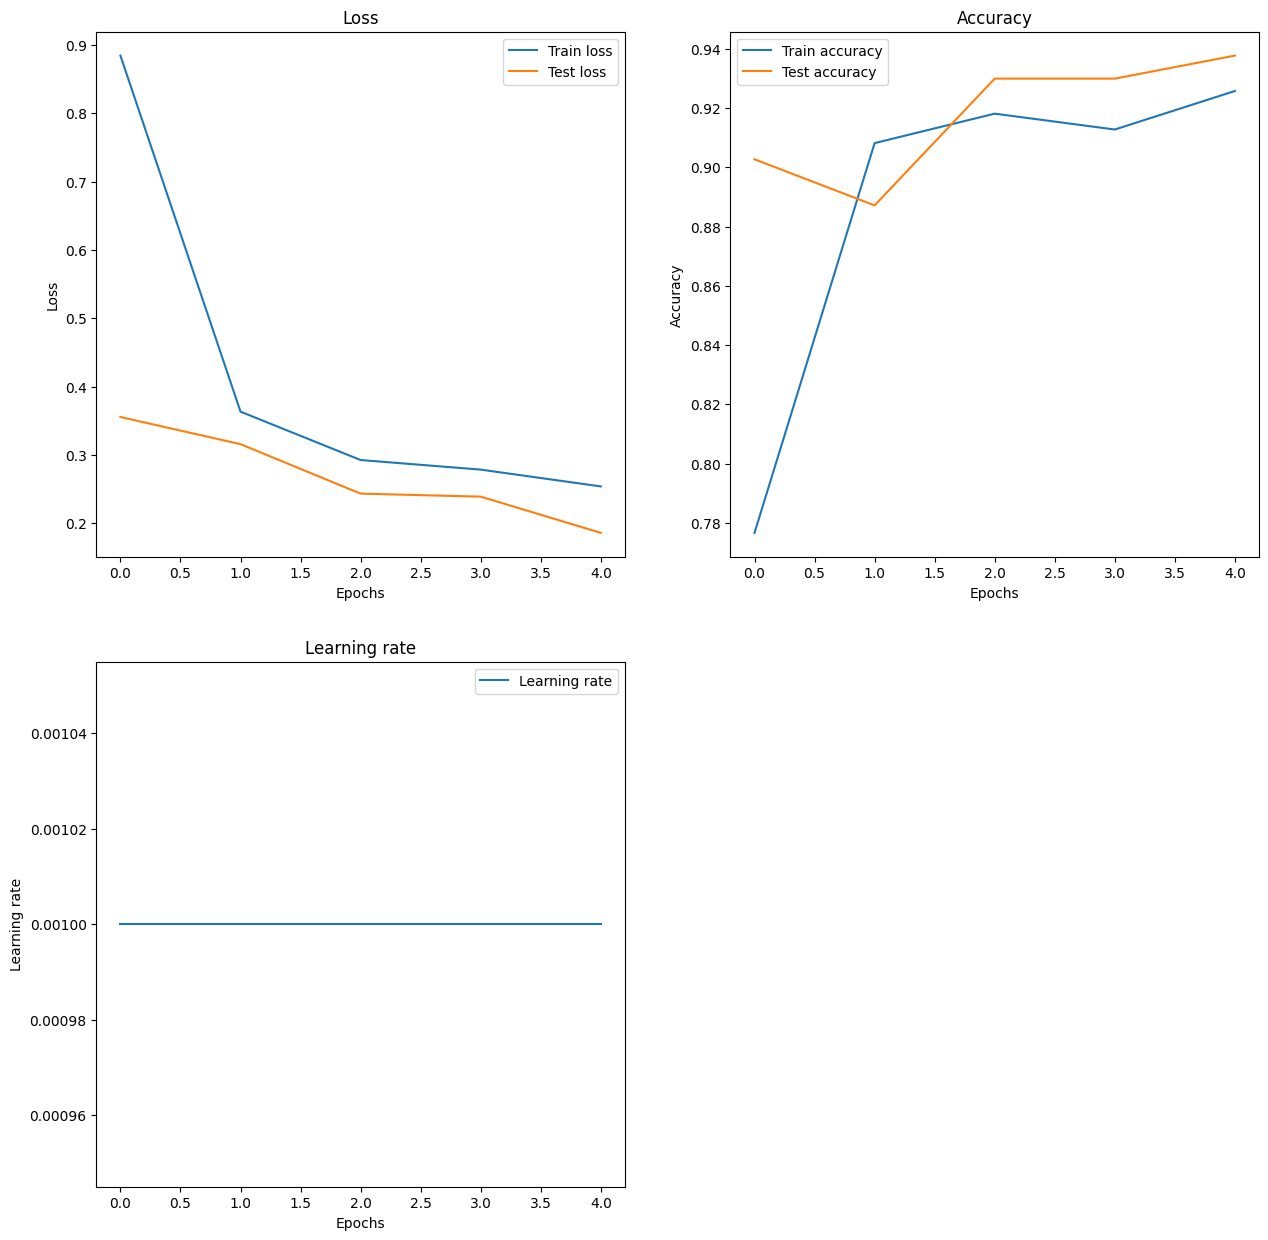

In [ ]:
# fit or train loop
torch.manual_seed(42)
epochs = 5

train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []
epoch_count = []
learning_rate = []

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_correct = 0
    total = 0
    #
    # y_pred_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # loss = loss_fn(y_logits, y_train) # we use y_logits here because CrossEntropyloss uses softmax internally. os we need raw model output
    # acc = accuracy_fn(y_true=y_train,
    #                   y_pred=y_pred_probs)

    for inputs, labels in train_dataloader:
      # Move inputs and labels to the device
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      y_logits = model(inputs)
      loss = loss_fn(y_logits, labels) # no need for softmax crosentropy does it internally.
      loss.backward()
      optimizer.step()
      # Statistics
      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(y_logits, 1) #ignore the value. just focus on indices i.e preds
      running_correct += (preds == labels).sum().item()
      total += labels.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    ### Testing
      # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss/ val_total
    val_acc = val_correct / val_total

    # Print out what's happening
    current_lr = scheduler.get_last_lr()[0]
    learning_rate.append(current_lr)

    if epoch % 1 == 0 or epoch + 1 == epochs:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(val_loss)
        train_acc_values.append(train_acc)
        test_acc_values.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} | "
        f"LR: {current_lr:.6f} | "
        f"Train Loss: {(100*train_loss):.4f}, Train Acc: {(100*train_acc):.4f} | "
        f"Val Loss: {(100*val_loss):.4f}, Val Acc: {(100*val_acc):.4f}")
    # Step the scheduler at the end of the epoch
    scheduler.step()



# Plot
plt.figure(figsize=(15, 15))
ax_1 = plt.subplot(2, 2, 1)
ax_2 = plt.subplot(2, 2, 2)
ax_3 = plt.subplot(2, 2, 3)
ax_1.plot(epoch_count,
         train_loss_values,
         label="Train loss")
ax_1.plot(epoch_count,
         test_loss_values,
         label="Test loss")
ax_2.plot(epoch_count,
         train_acc_values,
         label="Train accuracy")
ax_2.plot(epoch_count,
         test_acc_values,
         label="Test accuracy")
ax_3.plot(epoch_count,
         learning_rate,
         label="Learning rate")
ax_1.legend()
ax_2.legend()
ax_3.legend()

ax_1.set_xlabel("Epochs")
ax_2.set_xlabel("Epochs")
ax_3.set_xlabel("Epochs")

ax_1.set_ylabel("Loss")
ax_2.set_ylabel("Accuracy")
ax_3.set_ylabel("Learning rate")

ax_1.set_title("Loss")
ax_2.set_title("Accuracy")
ax_3.set_title("Learning rate")
plt.legend();

In [ ]:
# Note: the confusion matrix code we're about to write is a remix of scikit-learn's plot_confusion_matrix
# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):

  # Create the confusion matrix
  cm = confusion_matrix(y_true,y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] #normalize our confusion matrix

  n_classes = cm.shape[0]

  # Let's prettify it


  fig, ax = plt.subplots(figsize = figsize)

  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


# Set labels to the classes
  if classes is not None:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])  # setting labels 0 t0 1, as shape[0] is 2

  # Labels the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel = "True label",
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
        )

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Rotate x-axis labels
  plt.xticks(rotation=45)

  # Adjust the labels size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for direction colors
  threshold = (cm.max() + cm.min()) /2.  # give different shades of color respective to how many values are in each box , darker for more value

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size
            )
  plt.tight_layout()

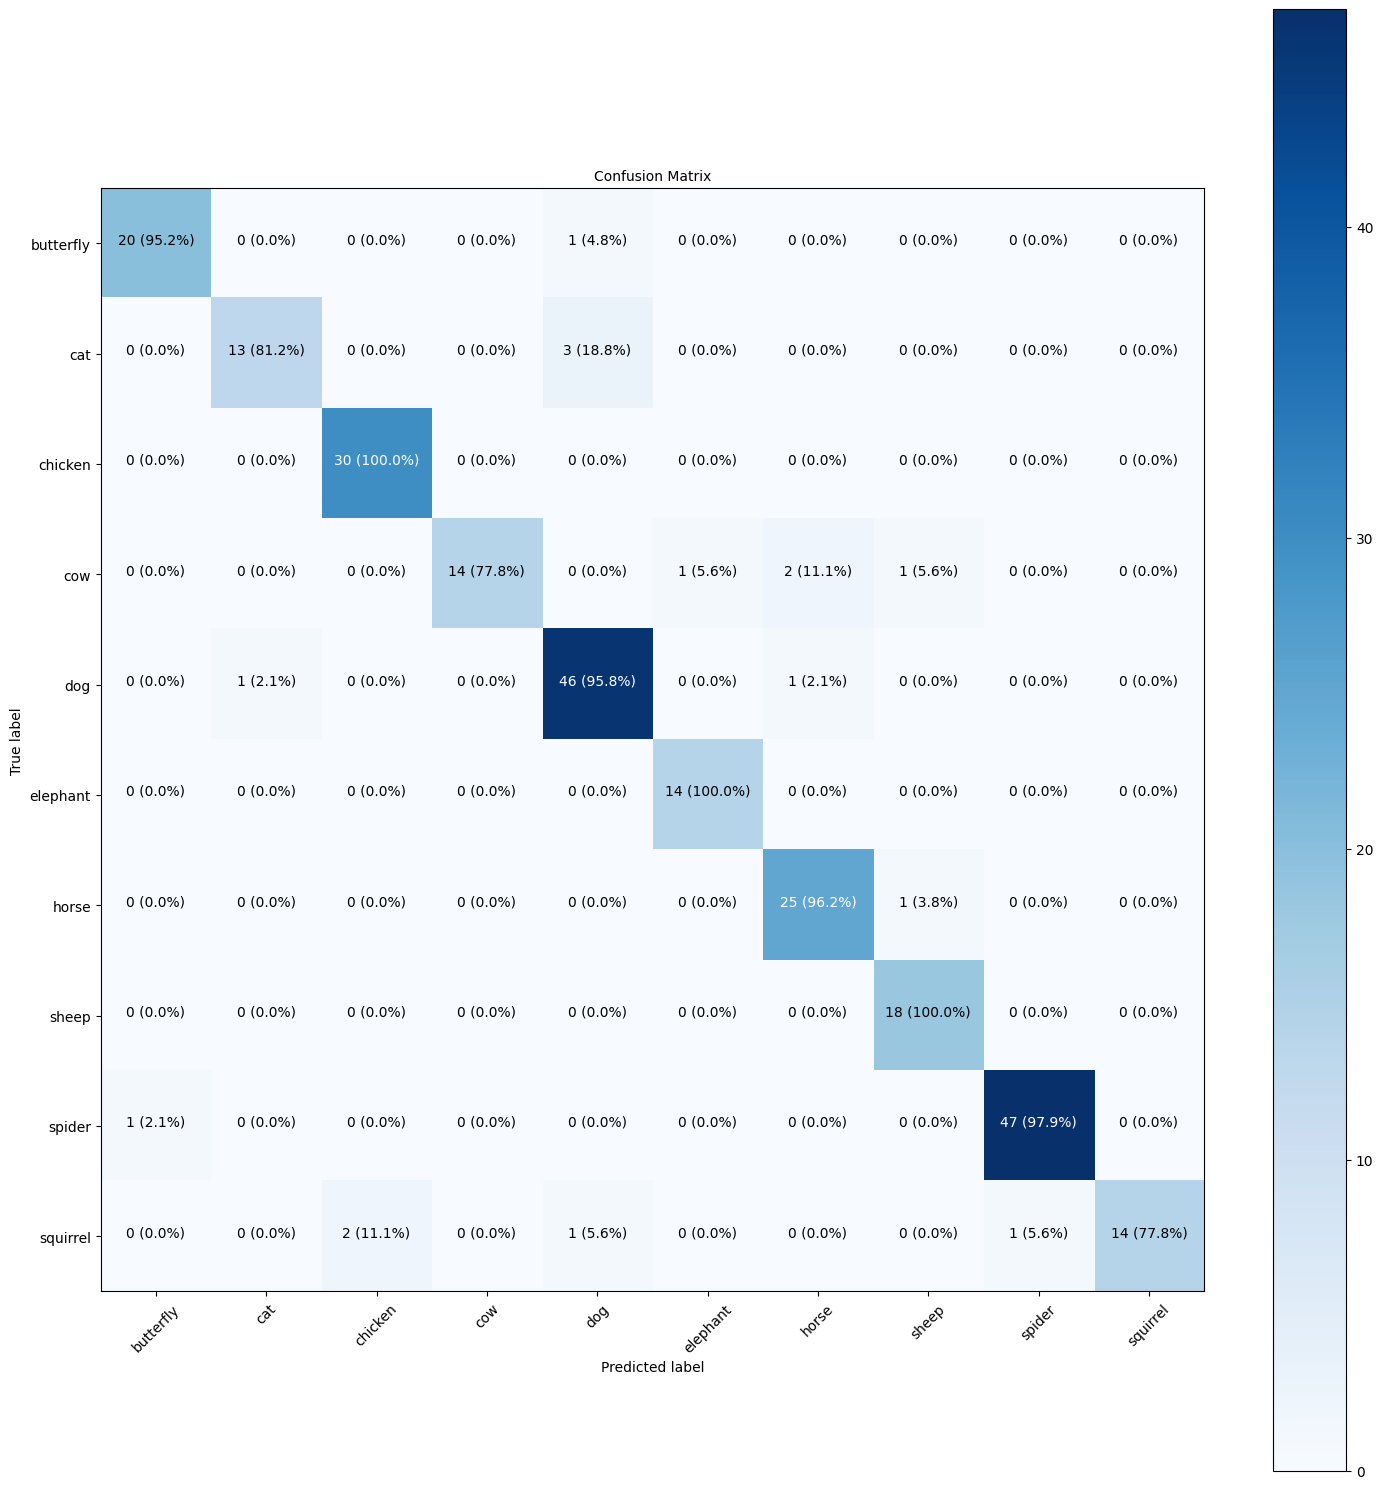

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Validation phase
model.eval()
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
# cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
make_confusion_matrix(all_labels,all_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10
                      )